In [1]:
# 1. Imports
import pandas as pd
import numpy as np
import re
from collections import Counter

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split

In [ ]:
# 2. Load the Datasets
# Load the Kaggle dataset
kaggle_df = pd.read_csv('Data/Data.csv')

# Load the ISOT datasets
true_df = pd.read_csv('Data/True.csv')
fake_df = pd.read_csv('Data/Fake.csv')

# For ISOT, assign labels
true_df['label'] = 1
fake_df['label'] = 0

In [ ]:
# 3. Combine the Datasets
# Combine the two ISOT datasets
isot_df = pd.concat([true_df, fake_df], ignore_index=True)

print("Kaggle dataset shape:", kaggle_df.shape)
print("ISOT dataset shape:", isot_df.shape)

# Combine Kaggle and ISOT data into one DataFrame
df = pd.concat([kaggle_df, isot_df], ignore_index=True)

# Shuffle the combined dataset
df = df.sample(frac=1, random_state=42).reset_index(drop=True)
print("Combined dataset shape:", df.shape)

Kaggle dataset shape: (20800, 5)
ISOT dataset shape: (44898, 5)
Combined dataset shape: (65698, 7)


In [ ]:
# 4. Handle Missing Values
# Drop rows missing 'text'
df = df.dropna(subset=['text'])

# Fill missing 'title' values with a placeholder
df['title'] = df['title'].fillna("No Title Provided")

if 'author' in df.columns:
    df['author'] = df['author'].fillna("Unknown")

In [5]:
# 5. Create the 'content' Column
# Combine 'title' and 'text' into a single text field
if 'content' not in df.columns:
    df['content'] = df['title'] + " " + df['text']

In [ ]:
# 6. Split into Training and Testing Sets
X = df['content']
y = df['label']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# 7. Preprocess Text for the LSTM (Updated)
def tokenize(text):
    # Convert to lowercase and split by word boundaries
    text = text.lower()
    tokens = re.findall(r'\b\w+\b', text)
    return tokens

# Build vocabulary from training texts, limiting to the top 10,000 words
all_tokens = []
for text in X_train:
    all_tokens.extend(tokenize(text))

freq = Counter(all_tokens)
max_vocab = 10000
vocab = {word: i+2 for i, (word, count) in enumerate(freq.most_common(max_vocab))}
vocab_size = len(vocab) + 2 

def text_to_sequence(text, vocab):
    tokens = tokenize(text)
    return [vocab.get(token, 1) for token in tokens]

# Convert texts to sequences of token indices
X_train_seq = [text_to_sequence(text, vocab) for text in X_train]
X_test_seq = [text_to_sequence(text, vocab) for text in X_test]

# Pad sequences to a fixed length (reduce max_len to lessen memory load)
max_len = 300 
def pad_sequence(seq, max_len):
    if len(seq) < max_len:
        return seq + [0] * (max_len - len(seq))
    else:
        return seq[:max_len]

X_train_pad = [pad_sequence(seq, max_len) for seq in X_train_seq]
X_test_pad = [pad_sequence(seq, max_len) for seq in X_test_seq]

# Convert padded sequences and labels to torch tensors
X_train_tensor = torch.tensor(X_train_pad, dtype=torch.long)
X_test_tensor = torch.tensor(X_test_pad, dtype=torch.long)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

In [ ]:
# 8. Create a PyTorch Dataset and DataLoader (Updated)
class NewsDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return self.texts[idx], self.labels[idx]

batch_size = 16
train_dataset = NewsDataset(X_train_tensor, y_train_tensor)
test_dataset = NewsDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [ ]:
# 8.1 Create a validation split from the training dataset
# Split train_dataset into training and validation subsets
from torch.utils.data import random_split

total_train = len(train_dataset)
val_size = int(0.2 * total_train)
train_size = total_train - val_size

train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# Create DataLoader for the validation set
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

print(f"New train set size: {len(train_dataset)}, Validation set size: {len(val_dataset)}")

New train set size: 42022, Validation set size: 10505


In [ ]:
def augment_sequence(seq, drop_prob=0.1):
    augmented = [token if token == 0 or np.random.rand() > drop_prob else 1 for token in seq]
    return augmented

# Update your NewsDataset to support augmentation.
class NewsDataset(Dataset):
    def __init__(self, texts, labels, augment=False, drop_prob=0.1):
        self.texts = texts
        self.labels = labels
        self.augment = augment
        self.drop_prob = drop_prob
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        # Get the text tensor for the given index.
        text = self.texts[idx]
        label = self.labels[idx]
        if self.augment:
            # Convert tensor to list, augment, and convert back.
            text_list = text.tolist()
            text_list = augment_sequence(text_list, drop_prob=self.drop_prob)
            text = torch.tensor(text_list, dtype=torch.long)
        return text, label

train_dataset = NewsDataset(X_train_tensor, y_train_tensor, augment=True, drop_prob=0.1)
# For validation and test sets, do not augment:
val_dataset = NewsDataset(X_test_tensor, y_test_tensor, augment=False)

In [ ]:
# Cell 9: Pretrain the LSTM Autoencoder

class LSTMAutoencoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, latent_dim):
        super(LSTMAutoencoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.encoder = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc_enc = nn.Linear(hidden_dim, latent_dim)
        self.fc_dec = nn.Linear(latent_dim, embedding_dim)
        self.decoder = nn.LSTM(embedding_dim, embedding_dim, batch_first=True)
        self.output_layer = nn.Linear(embedding_dim, vocab_size)
        
    def forward(self, x):
        embedded = self.embedding(x)
        _, (hidden, _) = self.encoder(embedded)
        latent = self.fc_enc(hidden[-1])
        hidden_dec = self.fc_dec(latent).unsqueeze(0)
        cell_dec = torch.zeros_like(hidden_dec)
        dec_out, _ = self.decoder(embedded, (hidden_dec, cell_dec))
        reconstructed = self.output_layer(dec_out)
        return latent, reconstructed

# Hyperparameters for pretraining
pretrain_epochs = 10
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
embedding_dim = 100
hidden_dim = 128
latent_dim = 64

autoencoder = LSTMAutoencoder(vocab_size, embedding_dim, hidden_dim, latent_dim)
autoencoder.to(device)

criterion_recon = nn.CrossEntropyLoss(ignore_index=0)
optimizer_ae = optim.Adam(autoencoder.parameters(), lr=0.001)

best_recon_loss = float('inf')
for epoch in range(pretrain_epochs):
    autoencoder.train()
    running_loss = 0.0
    for texts, _ in train_loader:  # Using only texts; labels are not used here.
        texts = texts.to(device)
        optimizer_ae.zero_grad()
        _, reconstructed = autoencoder(texts)
        loss = criterion_recon(reconstructed.view(-1, vocab_size), texts.view(-1))
        loss.backward()
        optimizer_ae.step()
        running_loss += loss.item() * texts.size(0)
    avg_loss = running_loss / len(train_dataset)
    print(f"Autoencoder Pretrain Epoch {epoch+1}/{pretrain_epochs} - Loss: {avg_loss:.4f}")
    if avg_loss < best_recon_loss:
        best_recon_loss = avg_loss
        best_autoencoder_state = autoencoder.state_dict()

# Optionally load the best state
autoencoder.load_state_dict(best_autoencoder_state)

Autoencoder Pretrain Epoch 1/10 - Loss: 0.5910
Autoencoder Pretrain Epoch 2/10 - Loss: 0.0019
Autoencoder Pretrain Epoch 3/10 - Loss: 0.0003
Autoencoder Pretrain Epoch 4/10 - Loss: 0.0001
Autoencoder Pretrain Epoch 5/10 - Loss: 0.0000
Autoencoder Pretrain Epoch 6/10 - Loss: 0.0000
Autoencoder Pretrain Epoch 7/10 - Loss: 0.0000
Autoencoder Pretrain Epoch 8/10 - Loss: 0.0000
Autoencoder Pretrain Epoch 9/10 - Loss: 0.0000
Autoencoder Pretrain Epoch 10/10 - Loss: 0.0000


<All keys matched successfully>

In [ ]:
# Cell 10: Define the Joint LSTM Autoencoder-Classifier Model with Increased Latent Dimension and Dropout
class JointLSTMAutoencoderClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, latent_dim, output_dim):
        super(JointLSTMAutoencoderClassifier, self).__init__()
        # Shared embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        
        # Encoder: LSTM to encode the input into a latent representation
        self.encoder = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc_enc = nn.Linear(hidden_dim, latent_dim)
        
        # Decoder: reconstruct the input from the latent vector
        self.fc_dec = nn.Linear(latent_dim, embedding_dim)
        self.decoder = nn.LSTM(embedding_dim, embedding_dim, batch_first=True)
        self.output_layer = nn.Linear(embedding_dim, vocab_size)
        
        # Classifier head with dropout regularization
        self.classifier = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.5),  # Added dropout here
            nn.Linear(64, output_dim)
        )
        
    def forward(self, x):
        embedded = self.embedding(x)
        _, (hidden, _) = self.encoder(embedded)
        latent = self.fc_enc(hidden[-1])
        
        # Classification output from latent representation
        class_output = self.classifier(latent)
        
        # Reconstruction branch
        hidden_dec = self.fc_dec(latent).unsqueeze(0)
        cell_dec = torch.zeros_like(hidden_dec)
        dec_out, _ = self.decoder(embedded, (hidden_dec, cell_dec))
        reconstructed = self.output_layer(dec_out)
        
        return latent, reconstructed, class_output

latent_dim = 128

In [ ]:
# Cell 11: Two‑Phase Joint Training with Validation, Early Stopping, and Alpha Scheduling

# Set device and hyperparameters (make sure these are defined earlier if needed)
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
embedding_dim = 100
hidden_dim = 128
output_dim = 2        # binary classification

# Instantiate the joint model
joint_model = JointLSTMAutoencoderClassifier(vocab_size, embedding_dim, hidden_dim, latent_dim, output_dim)
joint_model.to(device)

# Phase 1: Freeze the encoder and train only the classifier head.
for param in joint_model.encoder.parameters():
    param.requires_grad = False
joint_model.embedding.weight.requires_grad = False

criterion_recon = nn.CrossEntropyLoss(ignore_index=0)  
criterion_cls = nn.CrossEntropyLoss()                  
optimizer_joint = optim.Adam(joint_model.parameters(), lr=0.001)

patience = 3
best_val_acc = 0.0
patience_counter = 0

phase1_epochs = 5 
phase2_epochs = 5 
initial_alpha = 0.5

# Lists to store metrics for plotting
train_loss_list = []
val_loss_list = []
train_acc_list = []
val_acc_list = []

total_epochs = phase1_epochs + phase2_epochs

for epoch in range(total_epochs):
    # In Phase 2, unfreeze the encoder and embeddings
    if epoch == phase1_epochs:
        print("Unfreezing encoder and embedding layer for Phase 2...")
        for param in joint_model.encoder.parameters():
            param.requires_grad = True
        joint_model.embedding.weight.requires_grad = True
    
    # Adjust alpha with a decay schedule
    current_alpha = initial_alpha * (0.9 ** epoch)
    
    joint_model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    
    for texts, labels in train_loader:
        texts = texts.to(device)
        labels = labels.to(device)
        
        optimizer_joint.zero_grad()
        latent, reconstructed, class_output = joint_model(texts)
        
        loss_recon = criterion_recon(reconstructed.view(-1, vocab_size), texts.view(-1))
        loss_cls = criterion_cls(class_output, labels)
        loss = loss_recon + current_alpha * loss_cls
        
        loss.backward()
        optimizer_joint.step()
        
        running_loss += loss.item() * texts.size(0)
        _, predicted = torch.max(class_output, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    
    train_loss = running_loss / total_train
    train_acc = correct_train / total_train
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)
    print(f"Epoch {epoch+1}/{total_epochs} - Train Loss: {train_loss:.4f} - Train Acc: {train_acc:.4f} - Alpha: {current_alpha:.4f}")
    
    # Evaluate on validation set
    joint_model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for texts, labels in val_loader:
            texts = texts.to(device)
            labels = labels.to(device)
            _, _, class_output = joint_model(texts)
            loss_val = criterion_cls(class_output, labels)
            val_loss += loss_val.item() * texts.size(0)
            _, predicted_val = torch.max(class_output, 1)
            total_val += labels.size(0)
            correct_val += (predicted_val == labels).sum().item()
    
    avg_val_loss = val_loss / total_val
    val_acc = correct_val / total_val
    val_loss_list.append(avg_val_loss)
    val_acc_list.append(val_acc)
    print(f"Validation Loss: {avg_val_loss:.4f} - Validation Acc: {val_acc:.4f}")
    
    # Early stopping check
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        patience_counter = 0
        best_model_state = joint_model.state_dict()
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

Epoch 1/10 - Train Loss: 0.9999 - Train Acc: 0.5542 - Alpha: 0.5000
Validation Loss: 0.6785 - Validation Acc: 0.5813
Epoch 2/10 - Train Loss: 0.3093 - Train Acc: 0.5689 - Alpha: 0.4500
Validation Loss: 0.6734 - Validation Acc: 0.5880
Epoch 3/10 - Train Loss: 0.2759 - Train Acc: 0.5722 - Alpha: 0.4050
Validation Loss: 0.6730 - Validation Acc: 0.5895
Epoch 4/10 - Train Loss: 0.2477 - Train Acc: 0.5733 - Alpha: 0.3645
Validation Loss: 0.6723 - Validation Acc: 0.5914
Epoch 5/10 - Train Loss: 0.2223 - Train Acc: 0.5791 - Alpha: 0.3281
Validation Loss: 0.6737 - Validation Acc: 0.5869
Unfreezing encoder and embedding layer for Phase 2...
Epoch 6/10 - Train Loss: 0.2001 - Train Acc: 0.5757 - Alpha: 0.2952
Validation Loss: 0.7020 - Validation Acc: 0.5147
Epoch 7/10 - Train Loss: 0.1078 - Train Acc: 0.8156 - Alpha: 0.2657
Validation Loss: 0.1460 - Validation Acc: 0.9469
Epoch 8/10 - Train Loss: 0.0310 - Train Acc: 0.9558 - Alpha: 0.2391
Validation Loss: 0.0702 - Validation Acc: 0.9775
Epoch 9/10

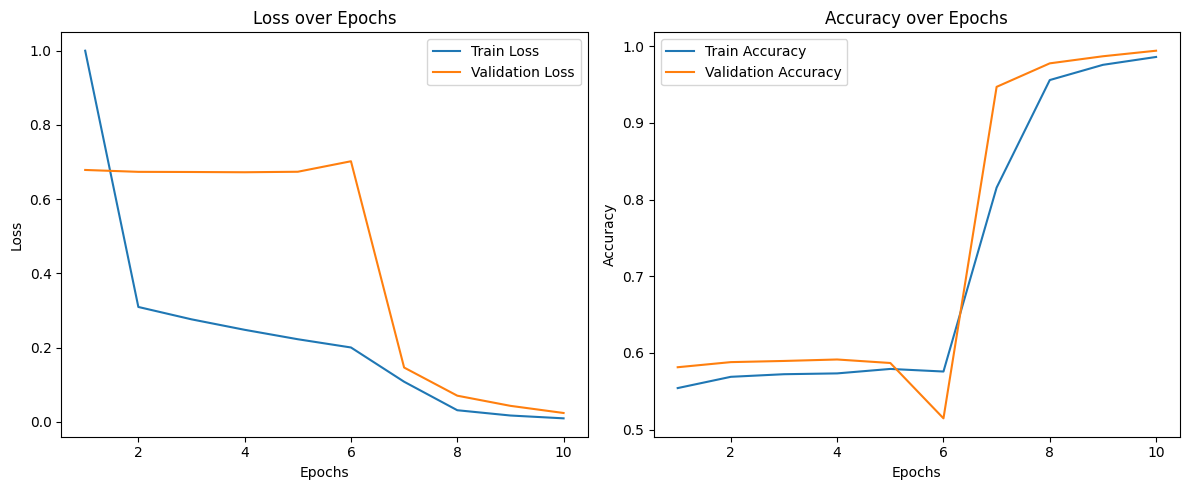

Joint Model Test Accuracy: 0.9671032592141334
Joint Model Test Precision: 0.9671271143242555
Joint Model Test Recall: 0.9671032592141334
Joint Model Test F1-Score: 0.9670975666997897


In [14]:
# Single Combined Cell for Plotting Metrics and Test Evaluation

import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Plot training and validation loss/accuracy curves
epochs_range = range(1, len(train_loss_list) + 1)

plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_loss_list, label='Train Loss')
plt.plot(epochs_range, val_loss_list, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_acc_list, label='Train Accuracy')
plt.plot(epochs_range, val_acc_list, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

# Evaluate on test set
joint_model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for texts, labels in test_loader:
        texts = texts.to(device)
        labels = labels.to(device)
        _, _, class_output = joint_model(texts)
        _, predicted = torch.max(class_output, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute metrics using scikit-learn
acc = accuracy_score(all_labels, all_preds)
prec = precision_score(all_labels, all_preds, average='weighted')
rec = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')

print("Joint Model Test Accuracy:", acc)
print("Joint Model Test Precision:", prec)
print("Joint Model Test Recall:", rec)
print("Joint Model Test F1-Score:", f1)